# Price Predictor Linear Regression Model

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import timedelta
from sqlalchemy import create_engine
import psycopg2
from config import db_password

## Load in data

In [2]:
# database address
host_name = 'database-1.cvhixt1fojqo.us-east-1.rds.amazonaws.com'

In [3]:
# create the database engine
db_string = f"postgresql://postgres:{db_password}@{host_name}:5432/Crypto_Data"

In [4]:
engine = create_engine(db_string)

In [5]:
ada_df = pd.read_sql("SELECT * FROM ada_orig", con=engine)

In [6]:
ada_df.shape

(1668, 9)

In [7]:
ada_df.dtypes

type_crypto       object
date_orig         object
daystarttoend      int64
open_ada         float64
high_ada         float64
low_ada          float64
close_ada        float64
volume_ada       float64
marketcap_ada    float64
dtype: object

In [8]:
ada_df.tail()

,type_crypto,date_orig,daystarttoend,open_ada,high_ada,low_ada,close_ada,volume_ada,marketcap_ada
1663,ada,2022-04-22,1664,0.909063,0.923691,0.894321,0.907236,1.201371e+09,2.867515e+10
1664,ada,2022-04-23,1665,0.906163,0.910934,0.883990,0.888474,7.555170e+08,2.826530e+10
1665,ada,2022-04-24,1666,0.887093,0.897949,0.880130,0.885290,5.521224e+08,2.800958e+10
1666,ada,2022-04-25,1667,0.885730,0.899764,0.830142,0.898860,1.175064e+09,2.721793e+10
1667,ada,2022-04-26,1668,0.897602,0.900668,0.819120,0.824140,1.311330e+09,2.730421e+10


## Transform datatypes

In [9]:
ada_df['date_orig'] = pd.to_datetime(ada_df["date_orig"])
ada_df.dtypes

type_crypto              object
date_orig        datetime64[ns]
daystarttoend             int64
open_ada                float64
high_ada                float64
low_ada                 float64
close_ada               float64
volume_ada              float64
marketcap_ada           float64
dtype: object

## Visualize Data

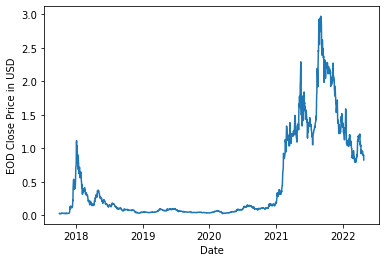

In [10]:
plt.plot(ada_df.date_orig, ada_df.close_ada)
plt.xlabel('Date')
plt.ylabel('EOD Close Price in USD')
plt.show()

## Adding in target variable

The target variable in this case will be the close price after one year for each piece of data

In [11]:
# intialize time delta for prediction
dt_days = 365

In [12]:
# initialize dt column for how far we want to predict
ada_df['date_pred'] = ada_df['date_orig'] + timedelta(days=dt_days)
ada_df.tail()

,type_crypto,date_orig,daystarttoend,open_ada,high_ada,low_ada,close_ada,volume_ada,marketcap_ada,date_pred
1663,ada,2022-04-22,1664,0.909063,0.923691,0.894321,0.907236,1.201371e+09,2.867515e+10,2023-04-22
1664,ada,2022-04-23,1665,0.906163,0.910934,0.883990,0.888474,7.555170e+08,2.826530e+10,2023-04-23
1665,ada,2022-04-24,1666,0.887093,0.897949,0.880130,0.885290,5.521224e+08,2.800958e+10,2023-04-24
1666,ada,2022-04-25,1667,0.885730,0.899764,0.830142,0.898860,1.175064e+09,2.721793e+10,2023-04-25
1667,ada,2022-04-26,1668,0.897602,0.900668,0.819120,0.824140,1.311330e+09,2.730421e+10,2023-04-26


In [13]:
# create a copy dataframe to pull target close price
ada_df_copy = ada_df.copy()
ada_df_copy.head()

,type_crypto,date_orig,daystarttoend,open_ada,high_ada,low_ada,close_ada,volume_ada,marketcap_ada,date_pred
0,ada,2017-10-02,1,0.024969,0.030088,0.019969,0.025808,8.310030e+07,567275650.8,2018-10-02
1,ada,2017-10-03,2,0.025671,0.027172,0.020575,0.020827,2.971484e+07,678634914.2,2018-10-03
2,ada,2017-10-04,3,0.020828,0.022962,0.020828,0.021973,1.243013e+07,569544386.4,2018-10-04
3,ada,2017-10-05,4,0.022035,0.022245,0.020839,0.021512,7.055960e+06,554868595.8,2018-10-05
4,ada,2017-10-06,5,0.021286,0.021576,0.018071,0.018481,6.207887e+06,521924570.1,2018-10-06


In [14]:
# merge dataframes to get target variable
ada_df_clean = ada_df.merge(ada_df_copy, how='left', left_on='date_pred', right_on='date_orig', suffixes=(None, '_pred'))
ada_df_clean.head()

,type_crypto,date_orig,daystarttoend,open_ada,high_ada,low_ada,close_ada,volume_ada,marketcap_ada,date_pred,type_crypto_pred,date_orig_pred,daystarttoend_pred,open_ada_pred,high_ada_pred,low_ada_pred,close_ada_pred,volume_ada_pred,marketcap_ada_pred,date_pred_pred
0,ada,2017-10-02,1,0.024969,0.030088,0.019969,0.025808,8.310030e+07,567275650.8,2018-10-02,ada,2018-10-02,366.0,0.084580,0.084872,0.082261,0.082447,35760764.25,2.168745e+09,2019-10-02
1,ada,2017-10-03,2,0.025671,0.027172,0.020575,0.020827,2.971484e+07,678634914.2,2018-10-03,ada,2018-10-03,367.0,0.082433,0.082525,0.078784,0.081010,38099788.00,2.091925e+09,2019-10-03
2,ada,2017-10-04,3,0.020828,0.022962,0.020828,0.021973,1.243013e+07,569544386.4,2018-10-04,ada,2018-10-04,368.0,0.081015,0.082836,0.080593,0.081493,29718641.86,2.128223e+09,2019-10-04
3,ada,2017-10-05,4,0.022035,0.022245,0.020839,0.021512,7.055960e+06,554868595.8,2018-10-05,ada,2018-10-05,369.0,0.081548,0.083553,0.080689,0.083287,27337740.85,2.118840e+09,2019-10-05
4,ada,2017-10-06,5,0.021286,0.021576,0.018071,0.018481,6.207887e+06,521924570.1,2018-10-06,ada,2018-10-06,370.0,0.083284,0.083888,0.080979,0.081556,27707604.59,2.131359e+09,2019-10-06


In [15]:
# drop empty rows
ada_df_pre_final = ada_df_clean.dropna()

In [16]:
# only include relevant features (X) and target variables (y)
ada_df_final = ada_df_pre_final[['open_ada','high_ada','low_ada','close_ada','volume_ada','marketcap_ada','close_ada_pred']]
ada_df_final.head()

,open_ada,high_ada,low_ada,close_ada,volume_ada,marketcap_ada,close_ada_pred
0,0.024969,0.030088,0.019969,0.025808,8.310030e+07,567275650.8,0.082447
1,0.025671,0.027172,0.020575,0.020827,2.971484e+07,678634914.2,0.081010
2,0.020828,0.022962,0.020828,0.021973,1.243013e+07,569544386.4,0.081493
3,0.022035,0.022245,0.020839,0.021512,7.055960e+06,554868595.8,0.083287
4,0.021286,0.021576,0.018071,0.018481,6.207887e+06,521924570.1,0.081556


## Create features and target

In [17]:
# features
X = ada_df_final.drop('close_ada_pred', axis=1)
X = X.values.reshape(-1,6)
X

array([[2.49695000e-02, 3.00877000e-02, 1.99693000e-02, 2.58084020e-02,
        8.31003000e+07, 5.67275651e+08],
       [2.56711360e-02, 2.71715620e-02, 2.05754950e-02, 2.08268640e-02,
        2.97148435e+07, 6.78634914e+08],
       [2.08280050e-02, 2.29620980e-02, 2.08280050e-02, 2.19732450e-02,
        1.24301341e+07, 5.69544386e+08],
       ...,
       [1.15819021e+00, 1.19861555e+00, 1.10137764e+00, 1.10840122e+00,
        3.87422224e+09, 3.59242060e+10],
       [1.10895563e+00, 1.15000000e+00, 1.03804659e+00, 1.09165379e+00,
        1.99437844e+09, 3.50263279e+10],
       [1.09446629e+00, 1.25155660e+00, 1.08767905e+00, 1.23722325e+00,
        2.79192760e+09, 3.79910718e+10]])

In [18]:
# target
y = ada_df_final['close_ada_pred']
y

0       0.082447
1       0.081010
2       0.081493
3       0.083287
4       0.081556
          ...   
1298    0.907236
1299    0.888474
1300    0.885290
1301    0.898860
1302    0.824140
Name: close_ada_pred, Length: 1303, dtype: float64

## Linear Regression Model

In [19]:
# initialize class for linear reg algorithms
model = LinearRegression()

In [20]:
# fit or train the data
model.fit(X,y)

LinearRegression()

In [21]:
# predict outcomes before current date
y_pred = model.predict(X)
print(y_pred.shape)

(1303,)


In [22]:
# slope
print(model.coef_)
# y-int
print(model.intercept_)

[-1.56112644e+00 -2.91721616e+00 -6.21355611e+00 -1.76142769e+00
  1.82440729e-11  4.03751699e-10]
0.6640361377087617


## Visualize Outcome

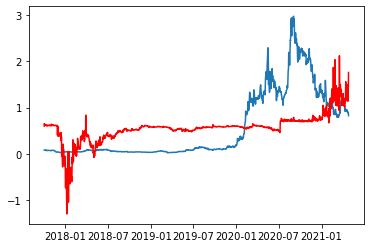

In [23]:
# display y_predictions based on the lin reg
plt.plot(ada_df_pre_final.date_orig, y)
plt.plot(ada_df_pre_final.date_orig, y_pred, color='red')
plt.show()

## Test Data (predicting the future)

In [24]:
ada_df_clean.tail()

,type_crypto,date_orig,daystarttoend,open_ada,high_ada,low_ada,close_ada,volume_ada,marketcap_ada,date_pred,type_crypto_pred,date_orig_pred,daystarttoend_pred,open_ada_pred,high_ada_pred,low_ada_pred,close_ada_pred,volume_ada_pred,marketcap_ada_pred,date_pred_pred
1663,ada,2022-04-22,1664,0.909063,0.923691,0.894321,0.907236,1.201371e+09,2.867515e+10,2023-04-22,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1664,ada,2022-04-23,1665,0.906163,0.910934,0.883990,0.888474,7.555170e+08,2.826530e+10,2023-04-23,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1665,ada,2022-04-24,1666,0.887093,0.897949,0.880130,0.885290,5.521224e+08,2.800958e+10,2023-04-24,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1666,ada,2022-04-25,1667,0.885730,0.899764,0.830142,0.898860,1.175064e+09,2.721793e+10,2023-04-25,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1667,ada,2022-04-26,1668,0.897602,0.900668,0.819120,0.824140,1.311330e+09,2.730421e+10,2023-04-26,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [25]:
ada_df_test = ada_df_clean.loc[ada_df_clean['date_pred'] > pd.datetime.now(),:]
ada_df_test.head()

/Users/briancha/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


,type_crypto,date_orig,daystarttoend,open_ada,high_ada,low_ada,close_ada,volume_ada,marketcap_ada,date_pred,type_crypto_pred,date_orig_pred,daystarttoend_pred,open_ada_pred,high_ada_pred,low_ada_pred,close_ada_pred,volume_ada_pred,marketcap_ada_pred,date_pred_pred
1308,ada,2021-05-02,1309,1.356884,1.359107,1.300000,1.330000,1.576118e+09,4.199584e+10,2022-05-02,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1309,ada,2021-05-03,1310,1.330000,1.380000,1.330000,1.365074,1.638442e+09,4.267333e+10,2022-05-03,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1310,ada,2021-05-04,1311,1.366804,1.366804,1.261954,1.273442,2.565489e+09,4.132156e+10,2022-05-04,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1311,ada,2021-05-05,1312,1.272910,1.490000,1.272910,1.480000,2.923481e+09,4.325395e+10,2022-05-05,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1312,ada,2021-05-06,1313,1.480000,1.700000,1.438379,1.660000,7.051294e+09,4.933762e+10,2022-05-06,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [26]:
X_test = ada_df_test[['open_ada','high_ada','low_ada','close_ada','volume_ada','marketcap_ada']]
X_test = X_test.values.reshape(-1,6)
X_test

array([[1.35688446e+00, 1.35910704e+00, 1.30000000e+00, 1.33000000e+00,
        1.57611798e+09, 4.19958409e+10],
       [1.33000000e+00, 1.38000000e+00, 1.33000000e+00, 1.36507447e+00,
        1.63844224e+09, 4.26733275e+10],
       [1.36680434e+00, 1.36680434e+00, 1.26195387e+00, 1.27344240e+00,
        2.56548928e+09, 4.13215583e+10],
       ...,
       [8.87093240e-01, 8.97948935e-01, 8.80130132e-01, 8.85290271e-01,
        5.52122445e+08, 2.80095823e+10],
       [8.85729533e-01, 8.99763645e-01, 8.30141973e-01, 8.98859960e-01,
        1.17506403e+09, 2.72179260e+10],
       [8.97601591e-01, 9.00667759e-01, 8.19120376e-01, 8.24139700e-01,
        1.31133047e+09, 2.73042080e+10]])

In [27]:
# predict outcomes before current date
y_pred_future = model.predict(X_test)
print(y_pred_future.shape)

(360,)


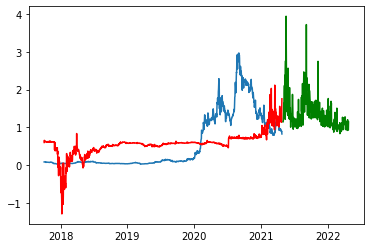

In [28]:
# display y_predictions based on the lin reg
plt.plot(ada_df_pre_final.date_orig, y)
plt.plot(ada_df_pre_final.date_orig, y_pred, color='red')
plt.plot(ada_df_test.date_orig, y_pred_future, color='green')
plt.show()